In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily

In [3]:
class dataExercisePrep_phillySummer:

    def __init__(self,crs,spraygrounds,picnicsites,swimmingpool,censustract,censustractHeat,council) -> None:
        ## Base
        self.crs                        = crs
        ## Data Cleaning.  Point Files
        # Spraygrounds Treatment:
        self._spraygrounds_raw          = pd.read_csv(spraygrounds)
        self.spraygrounds_geoTransform  = gpd.GeoDataFrame(
                                                self._spraygrounds_raw
                                                , geometry= (
                                                    gpd.points_from_xy(
                                                          self._spraygrounds_raw.X
                                                        , self._spraygrounds_raw.Y
                                                        , crs = self.crs
                                                    )
                                                )
                                            ).loc[
                                                :,[
                                                      'OBJECTID'
                                                    , 'PARK_NAME'
                                                    , 'SPRAY_STATUS'
                                                    , 'geometry'
                                                    , 'X'
                                                    , 'Y'
                                                ]
                                            ]

        # Picnic Grounds
        self._picnicgrounds_raw          = pd.read_csv(picnicsites)
        self.picnicgrounds_geoTransform  = gpd.GeoDataFrame(
                                                self._picnicgrounds_raw
                                                , geometry= (
                                                    gpd.points_from_xy(
                                                          self._picnicgrounds_raw.lng
                                                        , self._picnicgrounds_raw.lat
                                                        , crs = self.crs
                                                    )
                                                )
                                            ).loc[
                                                :,[
                                                      'objectid'
                                                    , 'park_name'
                                                    , 'table_count'
                                                    , 'geometry'
                                                    , 'lng'
                                                    , 'lat'
                                                ]
                                            ]

        
        # Swimming Pools
        self._swimmingpools_raw         = pd.read_csv(swimmingpool)
        self.swimmingpools_geoTransform     =  gpd.GeoDataFrame(
                                                self._swimmingpools_raw
                                                , geometry= (
                                                    gpd.points_from_xy(
                                                          self._swimmingpools_raw.X
                                                        , self._swimmingpools_raw.Y
                                                        , crs = self.crs
                                                    )
                                                )
                                            ).loc[
                                                :,[
                                                      'OBJECTID'
                                                    , 'PARK_NAME'
                                                    , 'POOL_TYPE'
                                                    , 'POOL_STATUS'
                                                    , 'geometry'
                                                    , 'X'
                                                    , 'Y'
                                                ]
                                            ]

        ## Data Cleaning: Vector Files
        self._censustracts_raw              = gpd.read_file(censustract)
        self._councildistricts_raw          = gpd.read_file(council)
        self._administrativeunits_raw       = gpd.overlay(
                                                      self._censustracts_raw
                                                    , self._councildistricts_raw
                                                )
        self._administrativeunits_transform  = self._administrativeunits_raw.assign(
                                                  unit_name                     = (

                                                                                        [f"AU{x}" for x in range(0,len(self._administrativeunits_raw))]
                                                                                )
                                                , censusTractName               = self._administrativeunits_raw['NAME10']
                                                , censusTractName_Full          = self._administrativeunits_raw['NAMELSAD10']
                                                , district                      = self._administrativeunits_raw['DISTRICT']
                                            )
        self.administrativeunits            = self._administrativeunits_transform.loc[
                                                :,
                                                    [
                                                          'district'
                                                        , 'censusTractName_Full'
                                                        , 'censusTractName'
                                                        , 'unit_name'
                                                    ]
                                                ]
        ## Data Base Files
        self._censusTractHeatIndex_raw      = pd.read_csv(censustractHeat)
        self.censusTractHeatIndex_transform = self._censusTractHeatIndex_raw.assign(
                                                      Tract_Name        = self._censusTractHeatIndex_raw['NAME10'].astype(int).astype('str')
                                                    , isHighHeatTract   = self._censusTractHeatIndex_raw['N_VERYHIGH'] 
                                                ).loc[
                                                    self._censusTractHeatIndex_raw['N_VERYHIGH'] == 1
                                                    ,[
                                                          'Tract_Name'
                                                        , 'isHighHeatTract'
                                                    ]
                                                ]
        
        ## Final Datasets:
        self.swimmingpools                  = gpd.sjoin(
                                                  self.swimmingpools_geoTransform
                                                , self._administrativeunits_transform
                                            ).loc[
                                                :,[
                                                      'PARK_NAME'
                                                    , 'POOL_TYPE'
                                                    , 'POOL_STATUS'
                                                    , 'unit_name'
                                                ]
                                            ]
        self.spraygrounds                   = gpd.sjoin(
                                                  self.spraygrounds_geoTransform
                                                , self._administrativeunits_transform
                                            ).loc[
                                                        :,[
                                                          'PARK_NAME'
                                                        , 'SPRAY_STATUS'
                                                        , 'unit_name'
                                                ]
                                            ]
        self.picnicgrounds              = gpd.sjoin(
                                              self.picnicgrounds_geoTransform
                                            , self._administrativeunits_transform
                                        ).loc[
                                                :,[
                                                      'park_name'
                                                    , 'table_count'
                                                    , 'unit_name'
                                                ]
                                        ]


    def writeDataExerciseFile(self,path):
        with pd.ExcelWriter(path) as file:
            self.censusTractHeatIndex_transform.to_excel(file,sheet_name='CensusTractHeatIndex',merge_cells=False,index = False)
            self.administrativeunits.to_excel(file,sheet_name = 'AdminUnits',merge_cells = False,index = False)
            self.swimmingpools.to_excel(file,sheet_name = 'SwimmingPools',merge_cells=False,index = False)
            self.spraygrounds.to_excel(file,sheet_name='SprayGrounds',merge_cells = False,index = False)
            self.picnicgrounds.to_excel(file,sheet_name = 'Picnic',merge_cells = False,index = False)



In [5]:
data = dataExercisePrep_phillySummer(
      'EPSG:4326'
    , r'datasets\spraygrounds.csv'
    , r'datasets\picnicSites.csv'
    , r'datasets\swimmingPools.csv'
    , r'datasets\Census_Tracts_2010.geojson'
    , r'datasets\censusTractHeatIndex.csv'
    , r'datasets\councilDistricts.geojson'
)


In [6]:
data.writeDataExerciseFile('text.xlsx')

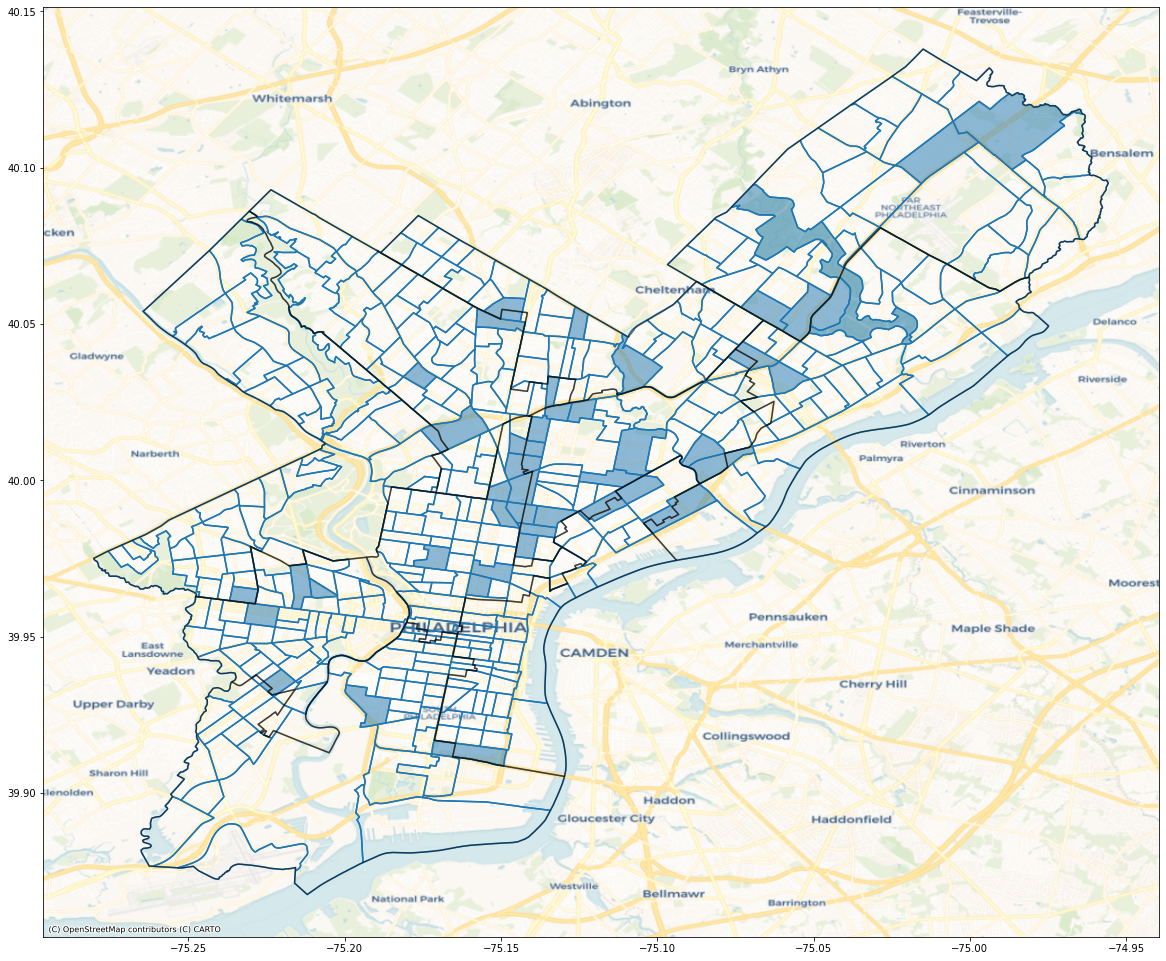

In [188]:

ax = data.censustracts.merge(
    data.censusTractHeatIndex_transform
    , how = 'right'
    , right_on = 'Tract_Name'
    , left_on = 'NAME10'
).plot(
    alpha = 0.5
    , figsize = (20,20)
)

data.censustracts.boundary.plot(
    ax = ax
)

data.councildistricts.boundary.plot(
      ax = ax
    , color = 'black'
    , alpha = 0.5
)
'''
gpd.overlay(
      data.censustracts[['geometry']]
    , data.councildistricts[['geometry']]
).boundary.plot(
      figsize = (20,20)
    , color = 'black'
    , ax = ax
)
'''
contextily.add_basemap(
      ax = ax
    , crs = data.crs
    , source = contextily.providers.CartoDB.Voyager
)

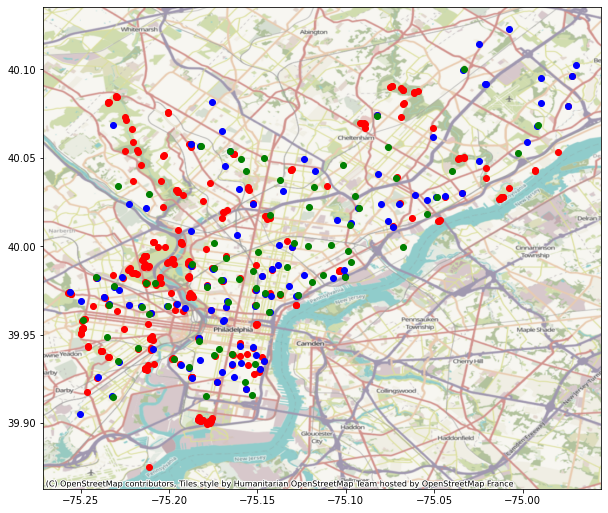

In [117]:
l1 =  data.picnicgrounds_geoTransform.set_crs('EPSG:4326').plot(color = 'r',figsize=(10,10))
l2 = data.spraygrounds_geoTransform.plot(color = 'b', ax = l1)
l3 = data.swimmingpools_geoTransform.plot(color = 'g', ax = l1)
contextily.add_basemap(ax = l1, source = contextily.providers.OpenStreetMap.HOT,crs = 'EPSG:4326')